## Investigating Message Intentions in Student-Chatbot Interactions across Three Different Courses

This notebook demonstrates the full pipeline implemented in the *EduChatEval* package, illustrating a potential use case in the absence of real data.
In this case, it simulates a researcher who is investigating 30 students' usage of chatbots in three different settings: an English, Biology, and Spanish course. 
The classification scheme used to do so is an adaption from the Wei et al., (2022) study: http://dx.doi.org/10.1016/
j.ipm.2021.102838. In this simulated scenario, a researcher is looking into the intentions behind the interactions of both the students and the chatbot.

The steps to do so are as follows:
1. A synthetic framework (i.e., an annotated dataset) is first generated.
2. Next, an interaction is simulated between two agents representing a 'student' and a 'tutor'.
3. A BERT classifier is then trained on the synthesized data. 
4. The trained classifier is then applied to the simulated conversation. In this case, both agents' outputs are analyzed.
5. Finally, the classified data is presented in a descriptive format, showcasing the researchers results. 

In [22]:
# package installation 
!pip install -q educhateval
!pip install -q pathlib
!pip install -q pandas

In [ ]:
# import libraries
from pathlib import Path
from educhateval import (FrameworkGenerator, 
                        DialogueSimulator,
                        PredictLabels,
                        Visualizer,)

import pandas as pd
import yaml

Generation of raw framework for 4 linguistic categories given in: prompt_default_4types.yaml:

In [ ]:
# import generator with the model name and API URL from the local server activated hosted LM studio 
generator = FrameworkGenerator(
    model_name="llama-3.2-3b-instruct", # the model already downloaded and loaded via LM Studio
    api_url="http://localhost:1234/v1/completions" # the address of locally hosted LM Studio API endpoint that handles generation requests. Consist of server host, port, and path.
    )

In [ ]:

# generate the framework by the given prompt 
df_4 = generator.generate_framework(
    prompt_path="../data/templates/prompt_default_4types.yaml", 
    num_samples=800,
    csv_out="../data/generated_tuning_data/synth_default_4types_800samples.csv",
)

Generating for category: Clarification
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Skipping invalid output for category 'Clarification': 'choices'
Generating for category: Small Talk
Generating for category: Question
Generating for category: Statement
Skipping invalid output for category 'Statement': 'choices'
Number of duplicates removed: 1025
→ Saved CSV: ../data/generated_tuning_data/synth_default_4types_800samples.csv


In [14]:
# Examples and length of each category
for category in df_4['category'].unique():
    print(f"\nCategory: {category}")
    print(f"Count: {len(df_4[df_4['category'] == category])}")
    print(df_4[df_4['category'] == category].sample(3))


Category: Clarification
Count: 792
                                                  text       category
200  You're asking to rephrase or expand upon a tex...  Clarification
619  I'd be happy to help you better understand the...  Clarification
224  Do you want me to provide a specific example o...  Clarification

Category: Small Talk
Count: 315
                                                   text    category
1545    Is it a nice day today? The weather is perfect.  Small Talk
1262     What's been the highlight of your week so far?  Small Talk
833   Is there anything new or exciting happening in...  Small Talk

Category: Question
Count: 387
                                                   text  category
1959  What are the top three social skills that peop...  Question
1716  What is the process by which plants make food ...  Question
2019  What is the definition of 'empowerment' in psy...  Question

Category: Statement
Count: 672
                                                   t

filtering for high-quality data using a small few-shot trained classifier:

In [4]:
# filtering the data with hyperparameter tuning
filtered_df = generator.filter_with_classifier(
    train_data="../data/templates/tiny_labeled_default.csv",
    synth_data=df_4,
    classifier_model_name="distilbert-base-uncased",
    tuning=True,
    tuning_params={
        "learning_rate": [5e-5, 3e-5, 2e-5],
        "per_device_train_batch_size": [8, 16, 32],
        "num_train_epochs": [3, 5, 8],
        "weight_decay": [0.001,0.01, 0.1]
    },
    filtered_save_path="../data/generated_tuning_data/final_4types_800.csv"

)

Max token: 39 Average token: 16.88888888888889


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-29 14:17:51,324] A new study created in memory with name: no-name-d270eeb5-45dd-4f27-812f-6477e5739f2a


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.557588,0.500000,0.421769,0.500000,0.428571
2,No log,1.502730,0.642857,0.845238,0.642857,0.610390
3,No log,1.452957,0.714286,0.842857,0.714286,0.730442
4,No log,1.408354,0.785714,0.914286,0.785714,0.811791
5,No log,1.371030,0.714286,0.761905,0.714286,0.706349
6,No log,1.342929,0.714286,0.761905,0.714286,0.706349
7,No log,1.325197,0.714286,0.761905,0.714286,0.706349
8,No log,1.317325,0.714286,0.761905,0.714286,0.706349


[I 2025-04-29 14:17:59,946] Trial 0 finished with value: 1.3173248767852783 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 8, 'weight_decay': 0.001}. Best is trial 0 with value: 1.3173248767852783.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.158403,0.785714,0.771429,0.785714,0.756236
2,No log,1.022219,0.928571,0.940476,0.928571,0.927850
3,No log,0.921010,0.928571,0.940476,0.928571,0.927850
4,No log,0.841866,0.928571,0.940476,0.928571,0.927850
5,No log,0.784954,0.928571,0.940476,0.928571,0.927850
6,No log,0.743674,0.928571,0.940476,0.928571,0.927850
7,No log,0.718806,0.928571,0.940476,0.928571,0.927850
8,No log,0.709388,0.928571,0.940476,0.928571,0.927850


[I 2025-04-29 14:18:08,848] Trial 1 finished with value: 0.7093876004219055 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 8, 'weight_decay': 0.1}. Best is trial 1 with value: 0.7093876004219055.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.565023,0.928571,0.940476,0.928571,0.927850
2,No log,0.491090,0.928571,0.940476,0.928571,0.927850
3,No log,0.467567,0.928571,0.940476,0.928571,0.927850


[I 2025-04-29 14:18:12,922] Trial 2 finished with value: 0.4675667881965637 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.1}. Best is trial 2 with value: 0.4675667881965637.



--- Summary of all tuning trials ---

 Trial  Validation Loss  Accuracy  Precision   Recall       F1  learning_rate  per_device_train_batch_size  num_train_epochs  weight_decay
     2         0.467567  0.928571   0.940476 0.928571 0.927850        0.00003                            8                 3         0.100
     1         0.709388  0.928571   0.940476 0.928571 0.927850        0.00003                           16                 8         0.100
     0         1.317325  0.714286   0.761905 0.714286 0.706349        0.00002                           32                 8         0.001

Best hyperparameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.1}


Map:   0%|          | 0/2166 [00:00<?, ? examples/s]

Filtered data saved to ../data/generated_tuning_data/final_4types_800.csv


In [5]:
# Examples and length:
filtered_df_dp = filtered_df.drop(columns=['label_id', 'predicted'])
for category in filtered_df_dp['category'].unique():
    print(f"\nCategory: {category}")
    print(f"Count: {len(filtered_df_dp[filtered_df_dp['category'] == category])}")
    print(filtered_df_dp[filtered_df_dp['category'] == category].sample(3))
    


Category: Clarification
Count: 612
                                                  text       category
108  You've already provided a clarification senten...  Clarification
277  I apologize, but I didn't receive the clarific...  Clarification
76   Can you rephrase the question and give an exam...  Clarification

Category: Small Talk
Count: 307
                                                   text    category
1017  How's the weather looking today? Anything plan...  Small Talk
991             How's the weather looking for us today?  Small Talk
822   I feel like it's been a while since we last ca...  Small Talk

Category: Question
Count: 346
                                                   text  category
1468            What are the different types of clouds?  Question
1335  What are the three main types of cognitive bia...  Question
1116                    What is the process of mitosis?  Question

Category: Statement
Count: 670
                                                   t

### Simulate interaction

In [2]:
# initiate simulator choosing the backend and model id (either huggingface or local, in this case local)
simulator = DialogueSimulator(backend="mlx", model_id="mlx-community/Qwen2.5-7B-Instruct-1M-4bit")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [3]:
# Load YAML file with seed messages
with open("../data/templates/student_seed_messages.yaml", "r") as f:
    seed_messages = yaml.safe_load(f)

# Displaying examples of seed messages
for course_name, course_content in seed_messages.items():
    seeds = course_content.get("seeds", [])
    print(f"\nCourse: {course_name}")
    print(f"Number of seeds: {len(seeds)}")
    print("Seed messages:")
    for seed in seeds:
        print(seed)



Course: english_course
Number of seeds: 5
Seed messages:
Hi, I'm struggling with writing essays. Can you help me improve?
Hi, Can you explain how to use the passive voice in English?
Hi, I'm preparing for an English exam—what are common grammar mistakes to watch out for?
Hi, How can I expand my vocabulary effectively?
Hi, Can you help me analyze this short story for class?

Course: biology_course
Number of seeds: 5
Seed messages:
Hi, I'm having trouble understanding cell division. Can you explain mitosis vs meiosis?
Hi, Can you help me review the parts of a plant cell?
Hi, How does natural selection work in evolution?
Hi, I need help with a biology lab report on photosynthesis.
Hi, What’s the difference between DNA and RNA?

Course: spanish_course
Number of seeds: 5
Seed messages:
Hi, I’m learning Spanish and need help practising.
Hi, how do I use past tense verbs in Spanish?
Hi, can you help me practice a short dialogue in Spanish?
Hi, what are some tips for improving Spanish pronunc

In [ ]:
# in this case we loop over subjects for each seed in each course with the models having corresponding prompts to the course
%%capture # output is muted to avoid cluttering the notebook as each dialogue otherwise would print

n_students_per_course = 30 # kind of like in a classroom 
course_dfs = {}

# Loop through each course and simulate dialogues
for course_name, course_content in seed_messages.items():
    seeds = course_content.get("seeds", [])
    n_seeds = len(seeds)
    all_course_dialogues = []

    for student_index in range(n_students_per_course):

        # Select seed message in round-robin fashion
        seed_message = seeds[student_index % n_seeds]

        df_single = simulator.simulate_dialogue(
            mode="general_task_solving",
            turns=8, 
            seed_message_input=seed_message, 
            custom_prompt_file="../data/templates/system_prompts.yaml"
        )

        # Add student ID and course info
        df_single["student_id"] = f"{course_name}_student_{student_index+1}"
        df_single["course"] = course_name

        all_course_dialogues.append(df_single)

    # Combine into one dataframe per course
    course_df = pd.concat(all_course_dialogues, ignore_index=True)
    course_dfs[course_name] = course_df

# Access the dataframes
biology_df = course_dfs["biology_course"]
english_df = course_dfs["english_course"]
spanish_df = course_dfs["spanish_course"]



In [11]:
english_df.head()

,turn,student_msg,tutor_msg,student_id,course
0,1,"Hi, I'm struggling with writing essays. Can yo...","Of course! Let's focus on structure: intro, th...",english_course_student_1,english_course
1,2,"Sure, that's helpful. What do you mean by a st...",A strong thesis statement clearly states your ...,english_course_student_1,english_course
2,3,Got it. What should I do if I get stuck on the...,Start with a topic sentence for each paragraph...,english_course_student_1,english_course
3,4,Thank you. How can I improve my introduction t...,"Start with a hook (fact, quote, question) to g...",english_course_student_1,english_course
4,5,"Great, thanks! How can I avoid common pitfalls...","Avoid: vague language, irrelevant examples, an...",english_course_student_1,english_course


### Predicting Labels
Training a classifier on the synthesized framework to predict the categories of the student messages in the dialogue data

In [ ]:
# loading the model and data for prediction
predictor = PredictLabels(model_name="distilbert-base-uncased")

In [22]:
# we annotate simulaniously the dataframes for each course
subject_frames = {
    "english": english_df,
    "biology": biology_df,
    "spanish": spanish_df,
}

annotated_frames = {}

# Annotate each subject frame
for subject_name, subject_frame in subject_frames.items():
    new_subject_frame = predictor.run_pipeline(
        train_data="../data/generated_tuning_data/final_qual_default.csv", 
        new_data=subject_frame, 
        text_column="text",
        label_column="category", 
        columns_to_classify=["student_msg", "tutor_msg"], 
        split_ratio=0.20,
        prediction_save_path=f"../data/final_outputs/{subject_name}_annotated_final.csv",
        tuning=True,
        tuning_params={
            "learning_rate": [5e-5, 3e-5, 2e-5],    
            "per_device_train_batch_size": [8, 16, 32],
            "num_train_epochs": [3, 5, 8],
            "weight_decay": [0.001, 0.01, 0.1],
        }
    )
    annotated_frames[subject_name] = new_subject_frame  # Save it


Max token: 47 Average token: 18.726923076923075


Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-29 17:49:06,177] A new study created in memory with name: no-name-94dc00f4-1b46-4a52-a68d-6a415e87dde2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.078872,1.000000,1.000000,1.000000,1.000000
2,No log,0.017965,1.000000,1.000000,1.000000,1.000000
3,No log,0.010580,1.000000,1.000000,1.000000,1.000000
4,No log,0.008250,1.000000,1.000000,1.000000,1.000000
5,No log,0.007691,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:49:52,653] Trial 0 finished with value: 0.007690837141126394 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001}. Best is trial 0 with value: 0.007690837141126394.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.004027,1.000000,1.000000,1.000000,1.000000
2,No log,0.002758,1.000000,1.000000,1.000000,1.000000
3,No log,0.002106,1.000000,1.000000,1.000000,1.000000
4,No log,0.001737,1.000000,1.000000,1.000000,1.000000
5,No log,0.001526,1.000000,1.000000,1.000000,1.000000
6,No log,0.001374,1.000000,1.000000,1.000000,1.000000
7,No log,0.001299,1.000000,1.000000,1.000000,1.000000
8,0.002800,0.001275,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:51:07,311] Trial 1 finished with value: 0.001275074202567339 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 8, 'weight_decay': 0.001}. Best is trial 1 with value: 0.001275074202567339.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.001111,1.000000,1.000000,1.000000,1.000000
2,No log,0.001001,1.000000,1.000000,1.000000,1.000000
3,No log,0.000939,1.000000,1.000000,1.000000,1.000000
4,No log,0.000899,1.000000,1.000000,1.000000,1.000000
5,No log,0.000887,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:51:45,496] Trial 2 finished with value: 0.0008872256148606539 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.001}. Best is trial 2 with value: 0.0008872256148606539.


Best hyperparameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.001}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.000798,1.000000,1.000000,1.000000,1.000000
2,No log,0.000726,1.000000,1.000000,1.000000,1.000000
3,No log,0.000684,1.000000,1.000000,1.000000,1.000000
4,No log,0.000658,1.000000,1.000000,1.000000,1.000000
5,No log,0.000651,1.000000,1.000000,1.000000,1.000000


Predicted data saved to ../data/final_outputs/english_annotated_final.csv
Max token: 47 Average token: 18.726923076923075


Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-29 17:52:25,802] A new study created in memory with name: no-name-b8a0c238-82ab-47cc-80b0-dff7aae69e4f


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.011852,1.000000,1.000000,1.000000,1.000000
2,No log,0.004707,1.000000,1.000000,1.000000,1.000000
3,No log,0.003653,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:52:54,195] Trial 0 finished with value: 0.003653238993138075 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.1}. Best is trial 0 with value: 0.003653238993138075.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.000834,1.000000,1.000000,1.000000,1.000000
2,No log,0.000447,1.000000,1.000000,1.000000,1.000000
3,No log,0.000315,1.000000,1.000000,1.000000,1.000000
4,0.001000,0.000258,1.000000,1.000000,1.000000,1.000000
5,0.001000,0.000242,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:53:59,321] Trial 1 finished with value: 0.00024150425451807678 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.1}. Best is trial 1 with value: 0.00024150425451807678.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.000145,1.000000,1.000000,1.000000,1.000000
2,No log,0.000113,1.000000,1.000000,1.000000,1.000000
3,No log,0.000104,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:54:38,349] Trial 2 finished with value: 0.00010443610517540947 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.01}. Best is trial 2 with value: 0.00010443610517540947.


Best hyperparameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.01}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.000072,1.000000,1.000000,1.000000,1.000000
2,No log,0.000059,1.000000,1.000000,1.000000,1.000000
3,No log,0.000056,1.000000,1.000000,1.000000,1.000000


Predicted data saved to ../data/final_outputs/biology_annotated_final.csv
Max token: 47 Average token: 18.726923076923075


Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-29 17:55:19,767] A new study created in memory with name: no-name-9aa56e18-95bb-4cb5-913d-df8526f878fd


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.098182,1.000000,1.000000,1.000000,1.000000
2,No log,0.026599,1.000000,1.000000,1.000000,1.000000
3,No log,0.020606,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:55:47,931] Trial 0 finished with value: 0.02060619555413723 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.001}. Best is trial 0 with value: 0.02060619555413723.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.011704,1.000000,1.000000,1.000000,1.000000
2,No log,0.008406,1.000000,1.000000,1.000000,1.000000
3,No log,0.007107,1.000000,1.000000,1.000000,1.000000
4,No log,0.006353,1.000000,1.000000,1.000000,1.000000
5,No log,0.006151,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:56:25,845] Trial 1 finished with value: 0.006151498295366764 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.001}. Best is trial 1 with value: 0.006151498295366764.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.003733,1.000000,1.000000,1.000000,1.000000
2,No log,0.002955,1.000000,1.000000,1.000000,1.000000
3,No log,0.002751,1.000000,1.000000,1.000000,1.000000


[I 2025-04-29 17:56:54,428] Trial 2 finished with value: 0.002751479856669903 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.1}. Best is trial 2 with value: 0.002751479856669903.


Best hyperparameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.1}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.001967,1.000000,1.000000,1.000000,1.000000
2,No log,0.001655,1.000000,1.000000,1.000000,1.000000
3,No log,0.001572,1.000000,1.000000,1.000000,1.000000


Predicted data saved to ../data/final_outputs/spanish_annotated_final.csv


In [25]:
### getting the confidence scores for each subject + standard dev
confidence_stats = {}

# Loop through each subject and calculate statistics
for subject, frame in annotated_frames.items():
    student_conf_avg = frame["predicted_confidence_student_msg"].mean()
    student_conf_std = frame["predicted_confidence_student_msg"].std()
    tutor_conf_avg = frame["predicted_confidence_tutor_msg"].mean()
    tutor_conf_std = frame["predicted_confidence_tutor_msg"].std()

    confidence_stats[subject] = {
        "student_avg_confidence": student_conf_avg,
        "student_confidence_std": student_conf_std,
        "tutor_avg_confidence": tutor_conf_avg,
        "tutor_confidence_std": tutor_conf_std,
    }

confidence_stats_df = pd.DataFrame(confidence_stats).T
confidence_stats_df




,student_avg_confidence,student_confidence_std,tutor_avg_confidence,tutor_confidence_std
english,0.959822,0.101665,0.924512,0.136673
biology,0.971892,0.086030,0.984685,0.052899
spanish,0.940464,0.110847,0.854149,0.179331


### Visualizations
Visualising the descriptive statistics of the classification above

In [ ]:
viz = Visualizer()

In [ ]:
biology_df_ann = pd.read_csv("../data/final_outputs/biology_annotated_final.csv")
english_df_ann = pd.read_csv("../data/final_outputs/english_annotated_final.csv")
spanish_df_ann = pd.read_csv("../data/final_outputs/spanish_annotated_final.csv")

##### Summary tables:

In [4]:
# Summary table
bio_summary = viz.create_summary_table(
    df=biology_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg"
)

print(bio_summary)

# english
eng_summary = viz.create_summary_table(
    df=english_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg"
)
print(eng_summary)

# spanish
spa_summary = viz.create_summary_table(
    df=spanish_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg"
)
print(spa_summary)


  Predicted Category  Student (n) Student (%)  Tutor (n) Tutor (%)
0      Clarification          175       72.9%         42     17.5%
1           Question           26       10.8%          4      1.7%
2         Small Talk           34       14.2%         29     12.1%
3          Statement            5        2.1%        165     68.8%
  Predicted Category  Student (n) Student (%)  Tutor (n) Tutor (%)
0      Clarification          192       80.0%        143     59.6%
1           Question            3        1.2%          5      2.1%
2         Small Talk           44       18.3%         38     15.8%
3          Statement            1        0.4%         54     22.5%
  Predicted Category  Student (n) Student (%)  Tutor (n) Tutor (%)
0      Clarification          171       71.2%         93     38.8%
1           Question            2        0.8%          2      0.8%
2         Small Talk           67       27.9%        102     42.5%
3          Statement            0        0.0%         43     1

##### Bar plots for each course:

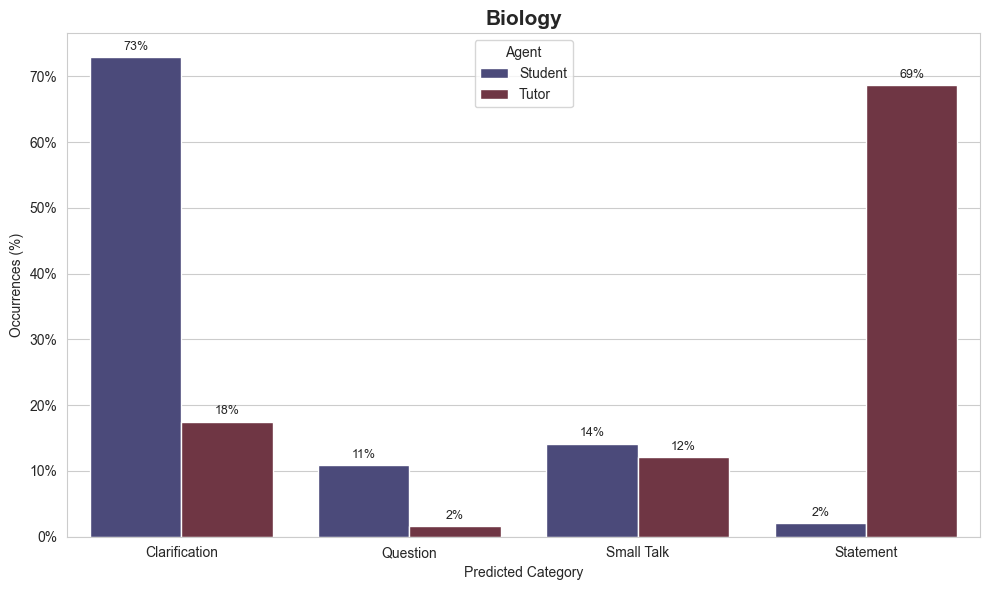

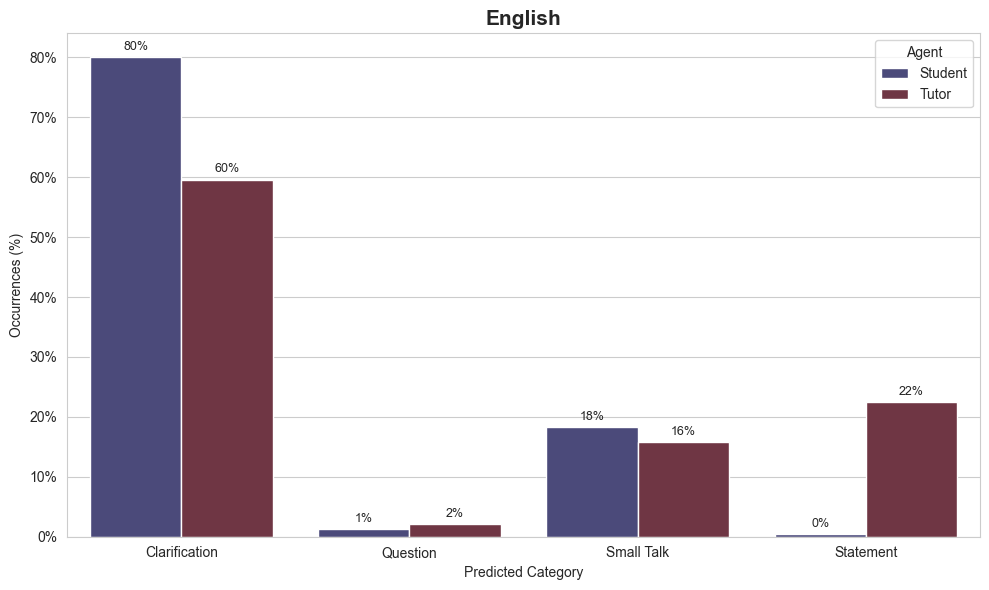

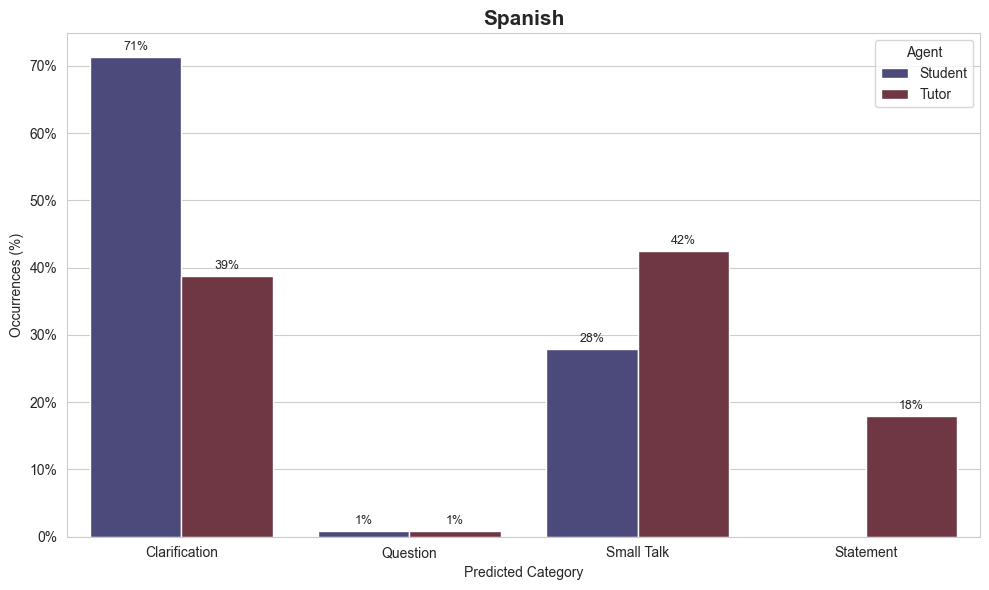

In [5]:

# Simple bar plot visualising the table
viz.plot_category_bars(
    df=biology_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    use_percent=True,
    title="Biology"
)

viz.plot_category_bars(
    df=english_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    use_percent=True,
    title="English"
)

viz.plot_category_bars(
    df=spanish_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    use_percent=True,
    title="Spanish"
)




##### Turn taking line plots for each course

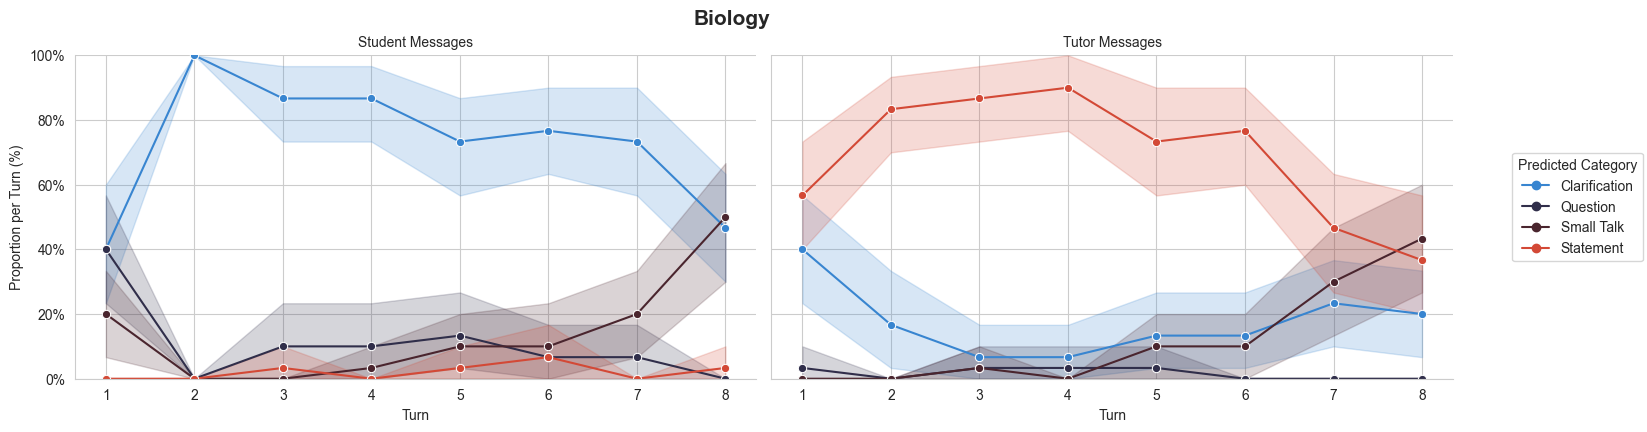

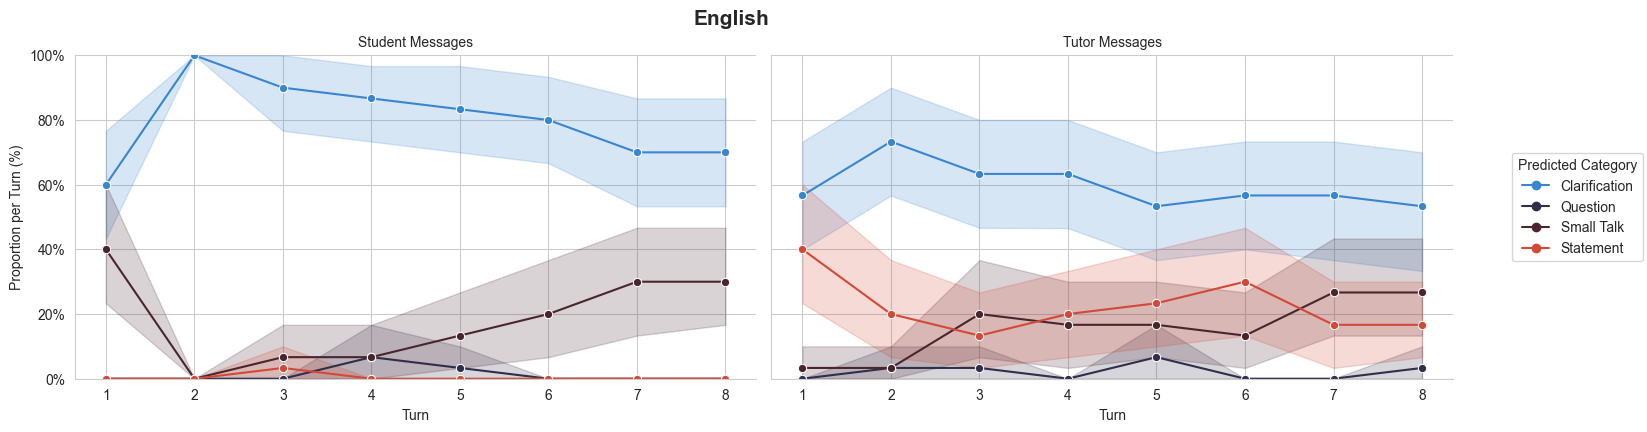

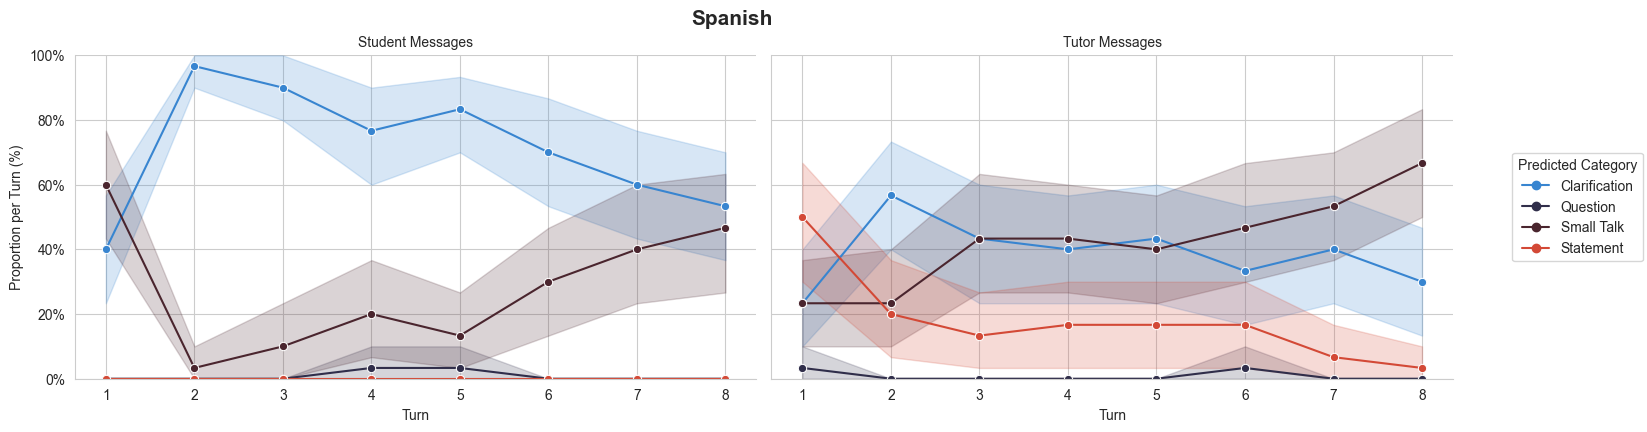

In [7]:
viz.plot_turn_trends(
    df=biology_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    session_col="student_id",
    show_ci=True,
    title="Biology",
)

viz.plot_turn_trends(
    df=english_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    session_col="student_id",  # <- required for CIs
    show_ci=True,
    title="English",
)

viz.plot_turn_trends(
    df=spanish_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    session_col="student_id",  # <- required for CIs
    show_ci=True,
    title="Spanish",
)

##### Sequential Category Dependencies For Biology

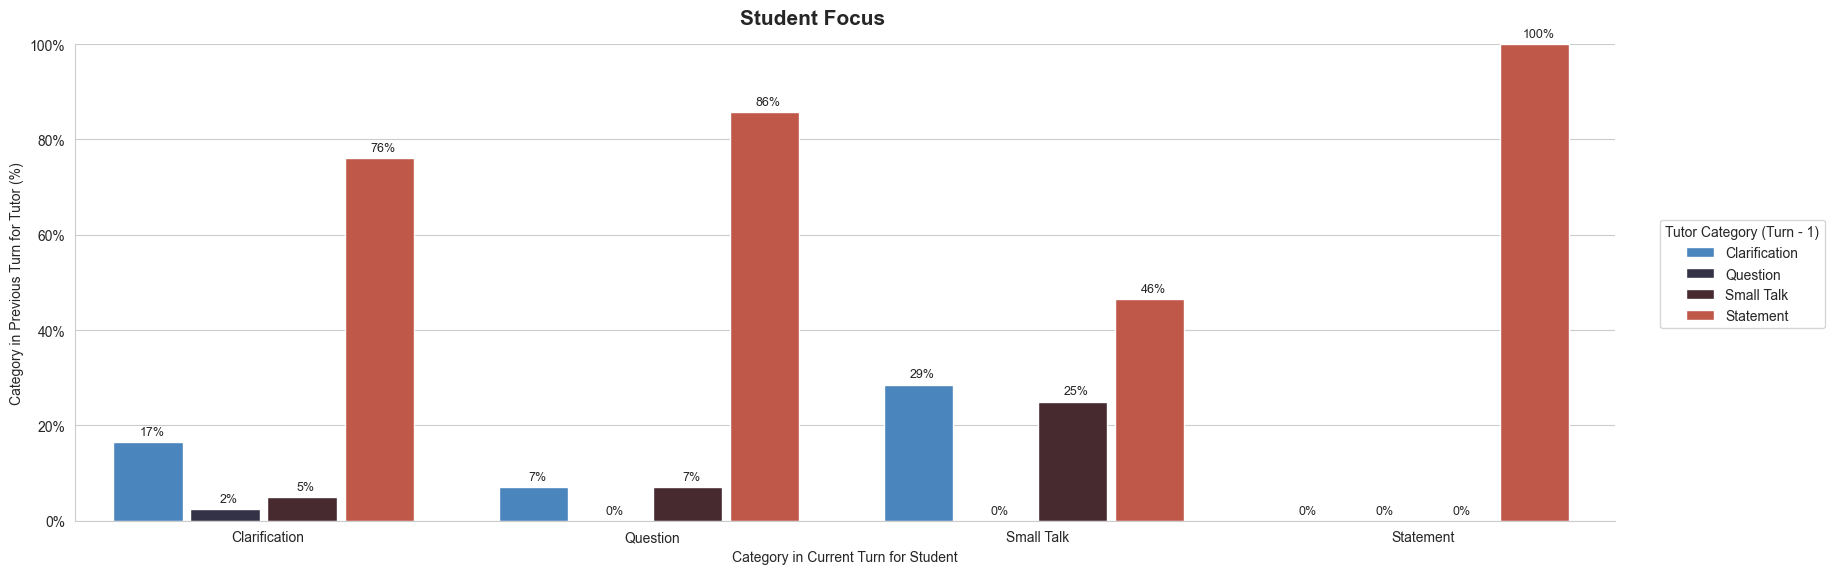

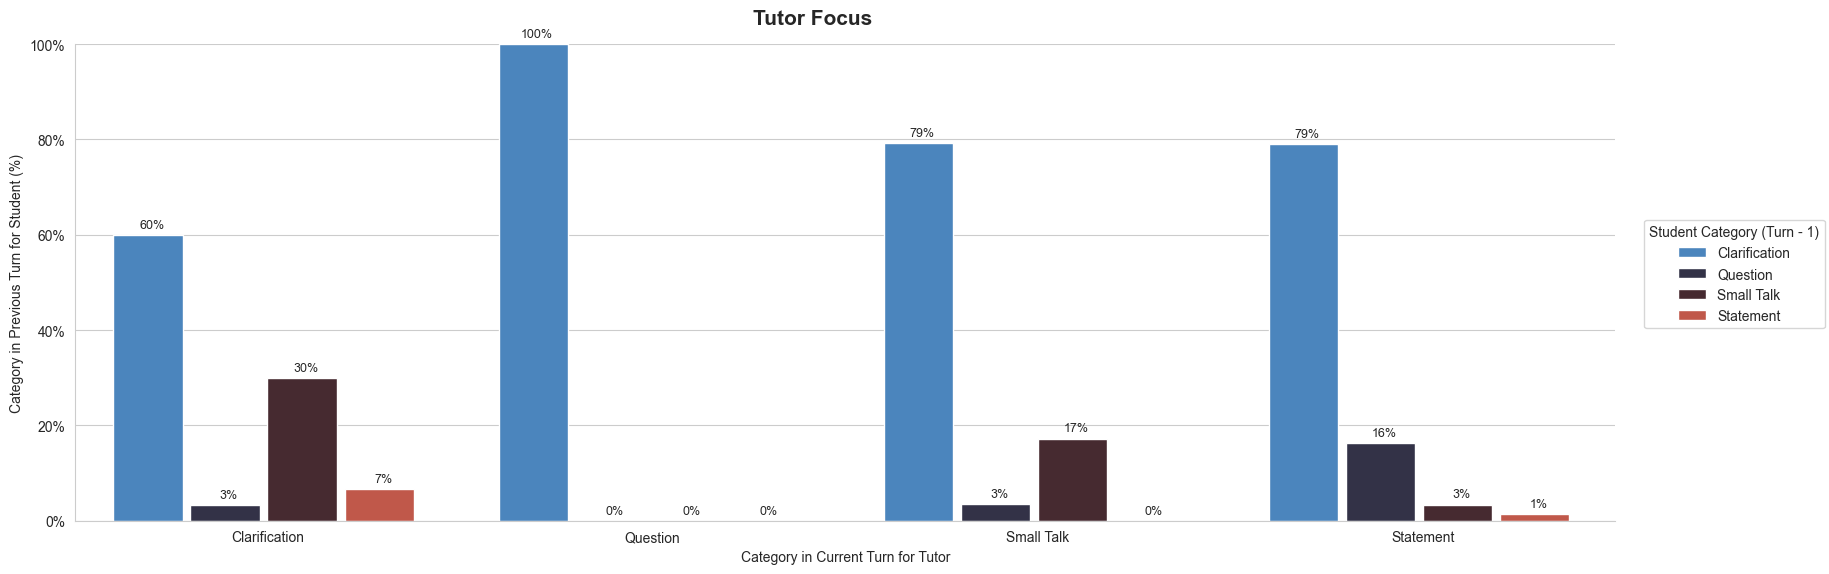

In [21]:
viz.plot_history_interaction(
    df=biology_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="student",
    use_percent=True,
    title="Biology - Student Focus",
)

viz.plot_history_interaction(
    df=biology_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="tutor",
    use_percent=True,
    title="Biology - Tutor Focus",
)




##### Sequential Category Dependencies For English

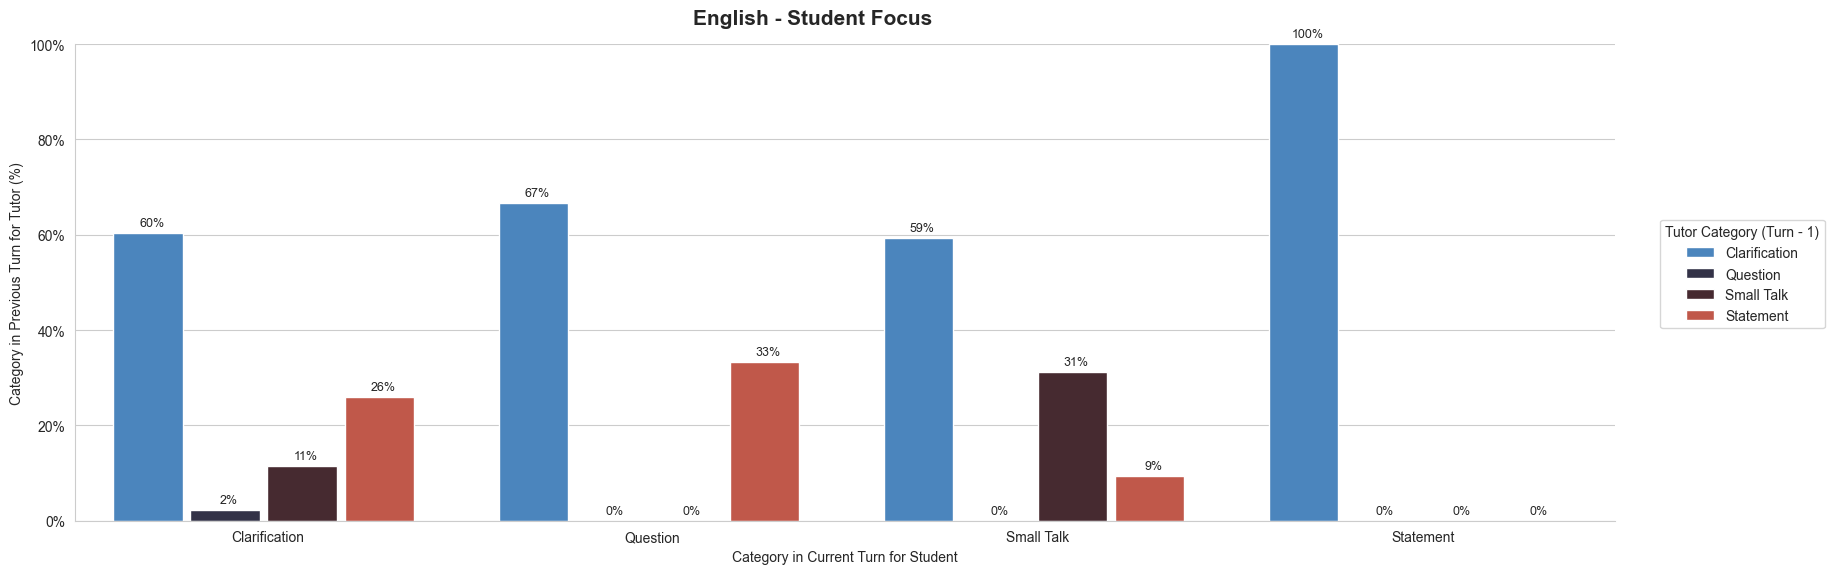

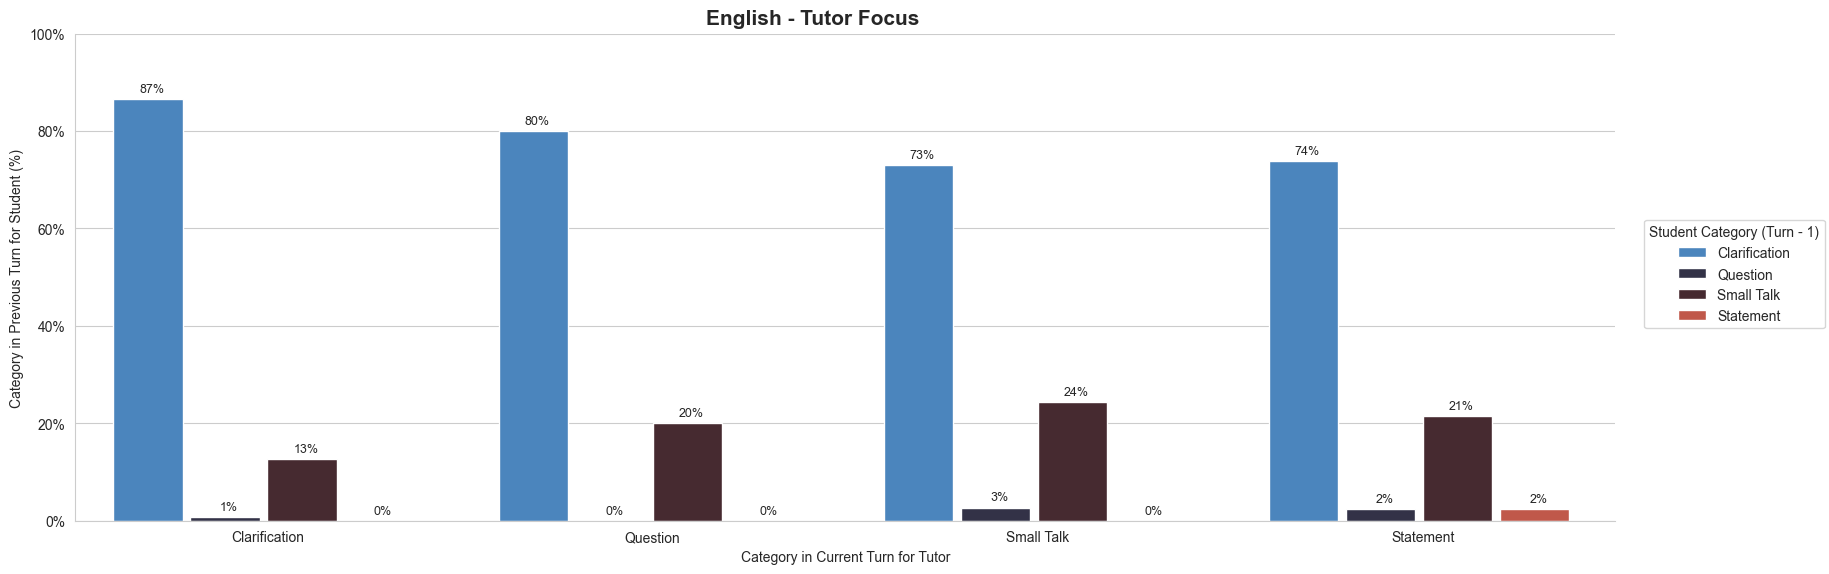

In [12]:
viz.plot_history_interaction(
    df=english_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="student",
    use_percent=True,
    title="English - Student Focus"
)

viz.plot_history_interaction(
    df=english_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="tutor",
    use_percent=True,
    title="English - Tutor Focus"
)




##### Sequential Category Dependencies For Spanish

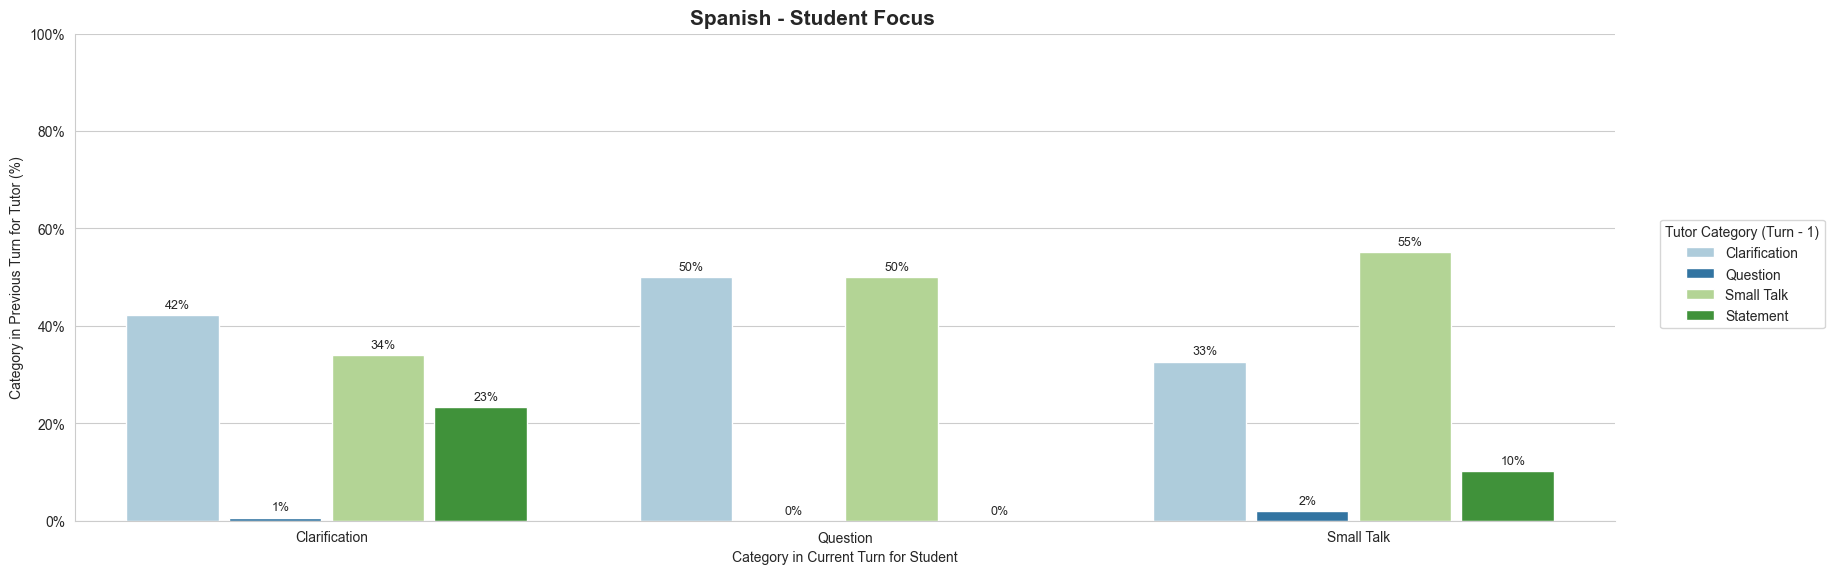

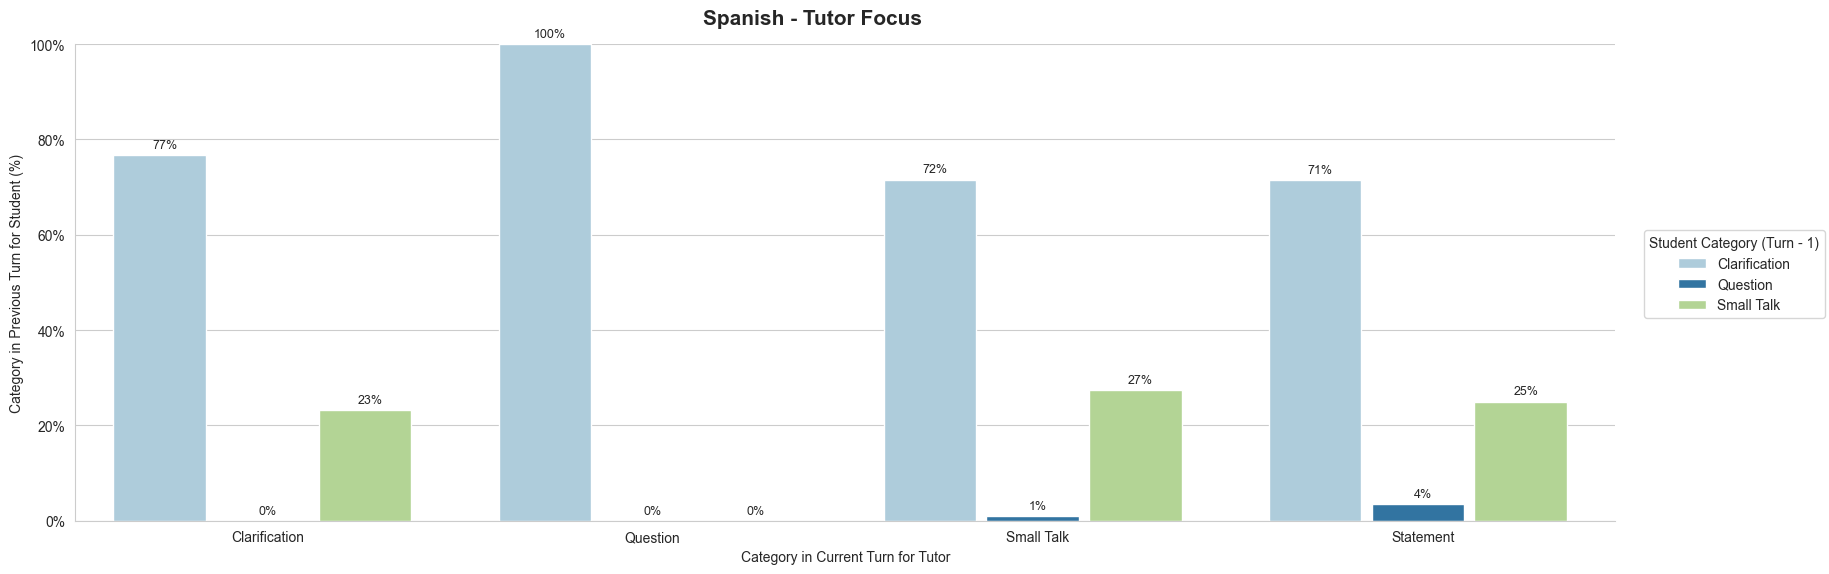

In [15]:
viz.plot_history_interaction(
    df=spanish_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="student",
    use_percent=True,
    title="Spanish - Student Focus",
    palette="Paired"
)

viz.plot_history_interaction(
    df=spanish_df_ann,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="tutor",
    use_percent=True,
    title="Spanish - Tutor Focus",
    palette="Paired"
)


